In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from torch import nn

## F-MNIST

In [2]:
dl_train = torch.utils.data.DataLoader(
    torchvision.datasets.FashionMNIST('./data/f_mnist', train=True, download=True))

dl_test  = torch.utils.data.DataLoader(
    torchvision.datasets.FashionMNIST('./data/f_mnist', train=False, download=True))

In [3]:
train_data   = dl_train.dataset.data.to(dtype=torch.float32)
train_labels = dl_train.dataset.targets

In [4]:
labels_txt = dl_train.dataset.classes

|Label|Description|
|-----|-----------|
| 0  |T-shirt/top| 
| 1  | Trouser   |
| 2  | Pullover  |
| 3  | Dress     |
| 4  | Coat      |
| 5  | Sandal   |
| 6  | Shirt    |
|7 | Sneaker|
|8| Bag |
|9| Ankle boot|

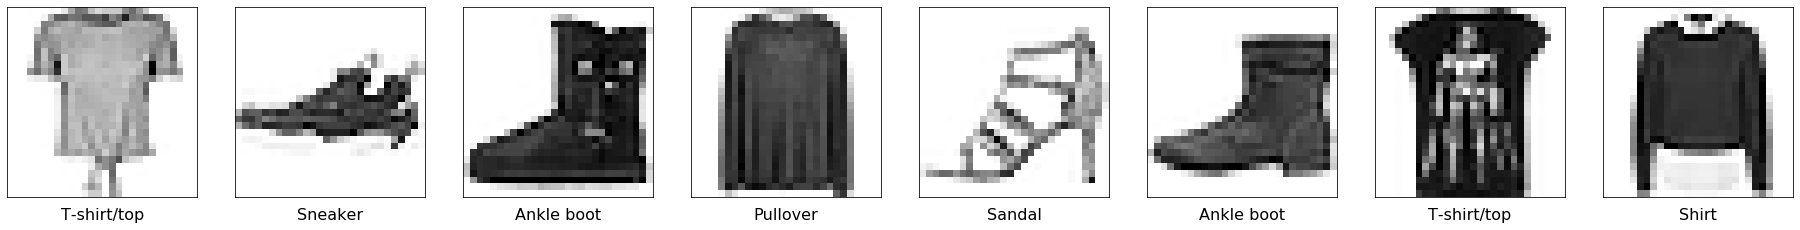

In [5]:
fig_mnist, ax = plt.subplots(1,8, figsize=(8*4,4))
sample = np.random.choice(50000,8)
for i in range(8):
    ax[i].imshow(train_data[sample[i]].numpy(), cmap='Greys');
    ax[i].set_xlabel(labels_txt[train_labels[sample[i]].item()], fontsize=16)
    ax[i].tick_params(axis='both', left=False, top=False, right=False, bottom=False)
    ax[i].xaxis.set_ticklabels([])
    ax[i].yaxis.set_ticklabels([])

In [6]:
train_dataset = torch.utils.data.TensorDataset( 
    (train_data).view(-1,28*28), 
    train_labels)

In [7]:
train_dataset, validation_dataset = torch.utils.data.random_split(train_dataset,(50000,10000))

In [8]:
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=100, 
                                           shuffle=True)

In [9]:
test_data   = dl_test.dataset.data.to(dtype=torch.float32)
test_labels = dl_test.dataset.targets
test_dataset = torch.utils.data.TensorDataset(
    (test_data/256).view(-1,28*28), test_labels)

In [10]:
loss_f = nn.CrossEntropyLoss()

```
model = torch.nn.Sequential(
    nn.Linear(28*28,1024), nn.ReLU(),
    nn.BatchNorm1d(1024),
    nn.Linear(1024,512), nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Linear(512,256), nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Linear(256,128), nn.ReLU(),
    nn.BatchNorm1d(128),
    nn.Linear(128,10)
)
```

In [11]:
class MyNet(torch.nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.l1 =  nn.Linear(28*28,1024)
        self.l2 =  nn.Linear(1024,512)
        self.l3 =  nn.Linear(512,256)
        self.l4 =  nn.Linear(256,128)
        self.l5 =  nn.Linear(128,10)
        
        self.b1 = nn.BatchNorm1d(1024)
        self.b2 = nn.BatchNorm1d(512)
        self.b3 = nn.BatchNorm1d(256)
        self.b4 = nn.BatchNorm1d(128)
        
        
    def forward(self, x):
        x = nn.functional.relu(self.l1(x))
        x = self.b1(x)
        x = nn.functional.relu(self.l2(x))
        x = self.b2(x)
        x = nn.functional.relu(self.l3(x))
        x = self.b3(x)
        x = nn.functional.relu(self.l4(x))
        x = self.b4(x)     
        return self.l5(x)
        
        

In [12]:
model = MyNet()

In [13]:
optim = torch.optim.SGD(model.parameters(),lr=0.0001)
scheduler =  torch.optim.lr_scheduler.CyclicLR(optim, 0.0, 1, step_size_up=1000, step_size_down=0, mode='triangular', gamma=0.999)

In [14]:
errors = []
lrs=[]
accuracy=[]
batches = 0
epochs = 0

In [15]:
%%time
for e in range(2):
    for d in train_loader:    
        model.train();
        optim.zero_grad()
        features, labels = d
        pred = model(features)
        loss = loss_f(pred, labels)
        errors.append(loss.item())
        lrs.append(optim.param_groups[0]['lr'])
        loss.backward()
        model.eval()
        with torch.no_grad():
            pred = torch.softmax(model(validation_dataset[:][0]),1)
        validation_ac = torch.sum(torch.argmax(pred,1)==validation_dataset[:][1]).to(dtype=torch.float32)/len(validation_dataset)
        accuracy.append(validation_ac)
        optim.step()
        scheduler.step()
        batches += 1
    epochs += 1   
print(loss, epochs, batches)        

tensor(0.5482, grad_fn=<NllLossBackward>) 2 1000
CPU times: user 37min 16s, sys: 35.1 s, total: 37min 51s
Wall time: 3min 28s


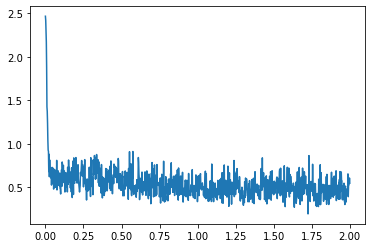

In [16]:
plt.plot(np.linspace(0,epochs, batches),errors)

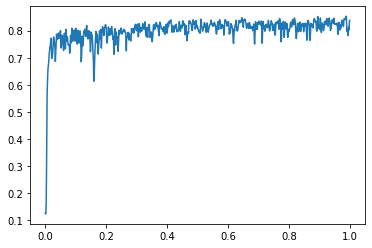

In [17]:
plt.plot(lrs, accuracy)

In [18]:
model.eval()
with torch.no_grad():
    pred = torch.softmax(model(train_dataset[:][0]),1)
    train_ac = torch.sum(torch.argmax(pred,1)==train_dataset[:][1]).to(dtype=torch.float32)/len(train_dataset)
train_ac  

tensor(0.8045)

In [19]:
%%time
model.eval()
with torch.no_grad():
    pred = torch.softmax(model(validation_dataset[:][0]),1)
    validation_ac = torch.sum(torch.argmax(pred,1)==validation_dataset[:][1]).to(dtype=torch.float32)/len(validation_dataset)
validation_ac    

CPU times: user 755 ms, sys: 16.6 ms, total: 771 ms
Wall time: 129 ms


tensor(0.8038)

In [20]:
optim = torch.optim.SGD(model.parameters(),lr=0.0001)
scheduler =  torch.optim.lr_scheduler.CyclicLR(optim, 0.0, 0.3, step_size_up=1000, step_size_down=1000, mode='triangular2', gamma=0.9)

In [21]:
errors = []
lrs=[]
batches = 0
epochs = 0

In [22]:
%%time
model.train()
for e in range(20):
    for d in train_loader:        
        optim.zero_grad()
        features, labels = d
        pred = model(features)
        loss = loss_f(pred, labels)
        errors.append(loss.item())
        lrs.append(optim.param_groups[0]['lr'])
        loss.backward()
        optim.step()
        scheduler.step()
        batches += 1
    epochs += 1   
print(loss, epochs, batches)        

tensor(0.1751, grad_fn=<NllLossBackward>) 20 10000
CPU times: user 1h 6min 54s, sys: 44.8 s, total: 1h 7min 38s
Wall time: 6min 13s


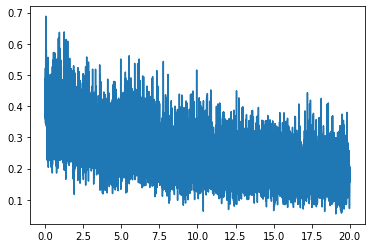

In [23]:
plt.plot(np.linspace(0,epochs, batches),errors);

In [24]:
model.eval()
with torch.no_grad():
    pred = torch.softmax(model(train_dataset[:][0]),1)
    train_ac = torch.sum(torch.argmax(pred,1)==train_dataset[:][1]).to(dtype=torch.float32)/len(train_dataset)
train_ac  

tensor(0.9383)

In [25]:
model.eval()
with torch.no_grad():
    pred = torch.softmax(model(validation_dataset[:][0]),1)
    validation_ac = torch.sum(torch.argmax(pred,1)==validation_dataset[:][1]).to(dtype=torch.float32)/len(validation_dataset)
validation_ac    

tensor(0.8977)

In [26]:
model.eval()
with torch.no_grad():
    pred = torch.softmax(model(validation_dataset[:][0]),1)
    no_good = torch.argmax(pred,1)!=validation_dataset[:][1]    

In [27]:
no_good_images = validation_dataset.dataset[np.asarray(validation_dataset.indices)][0][no_good]
no_good_labels = validation_dataset.dataset[np.asarray(validation_dataset.indices)][1][no_good]

In [3]:
k = 23
should_be = dl_train.dataset.classes[no_good_labels[k]]
predicted = dl_train.dataset.classes[np.argmax(pred[no_good][k])]
plt.imshow(no_good_images[k].numpy().reshape(28,28),cmap='Greys')
plt.xlabel("Is %s should be  %s" % (predicted, should_be))

NameError: name 'dl_train' is not defined

### Performance metrics

### Default Baseline Models

### Gather more data?

### Hyperparameters tuning

#### Grid search

#### Random search

#### Optimization